In [2]:
from tabulate import tabulate
import pandas as pd

df = pd.DataFrame({'col_two' : [0.0001, 1e-005 , 1e-006, 1e-007],
                   'column_3' : ['ABCD', 'ABCD', 'long string', 'ABCD']})
print(tabulate(df, headers='keys', tablefmt='psql'))

+----+-----------+-------------+
|    |   col_two | column_3    |
|----+-----------+-------------|
|  0 |    0.0001 | ABCD        |
|  1 |    1e-05  | ABCD        |
|  2 |    1e-06  | long string |
|  3 |    1e-07  | ABCD        |
+----+-----------+-------------+


In [3]:
import pandas as pd
SELECT_COLUMN = [1,2,4,6,11] # We only consider price, date of the purchase, property type, lease duration and town
df = pd.read_csv("data/pp-complete.csv", names=["price", "date", "ptype", "duration", "town"], sep=",", usecols=SELECT_COLUMN)

In [4]:
df['isLondon'] = [1 if i == "LONDON" else 0 for i in df['town']]
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [3]:
# Create one-hot encoder and train it on the dataset
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoder.fit(df[["ptype", "duration"]])

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [5]:
a = encoder.transform(df[["ptype", "duration"]])

In [9]:
a = a.toarray()

In [6]:
df['year'] = df.date.dt.year

In [14]:
import numpy as np
np.concatenate([a, df[['year']].values], axis=1).shape

(25180684, 9)

Text(0.5, 0, 'Log SalePrice')

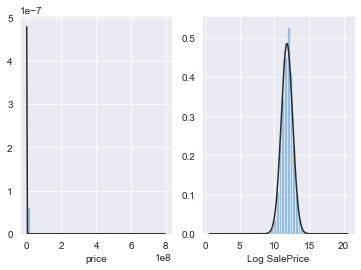

In [228]:
plt.subplot(1, 2, 1)
sns.distplot(df.price, kde=False, fit = norm)

plt.subplot(1, 2, 2)
sns.distplot(np.log(df.price + 1), kde=False, fit = norm)
plt.xlabel('Log SalePrice')

In [229]:
df.price = np.log1p(df.price)

In [231]:
df.price.describe()

count    2.518068e+07
mean     1.180984e+01
std      8.204587e-01
min      6.931472e-01
25%      1.128666e+01
50%      1.184224e+01
75%      1.233711e+01
max      2.049573e+01
Name: price, dtype: float64

In [21]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
import pylab 

from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from scipy.special import boxcox1p
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler, PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest, RFECV, SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.feature_extraction import FeatureHasher
from sklearn.decomposition import PCA, KernelPCA
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, OrthogonalMatchingPursuit, Lasso, LassoLarsIC, ElasticNet, ElasticNetCV
from sklearn.linear_model import SGDRegressor, PassiveAggressiveRegressor, HuberRegressor, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [254]:
display(df.describe().transpose())


,count,mean,std,min,25%,50%,75%,max
price,25180684.000,11.810,0.820,0.693,11.287,11.842,12.337,20.496
isLondon,25180684.000,0.078,0.268,0.000,0.000,0.000,0.000,1.000
year,25180684.000,2006.567,7.216,1995.000,2001.000,2006.000,2013.000,2020.000


In [255]:
def rstr(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis = 1)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1, sort=False)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ration', 'uniques', 'skewness', 'kurtosis', corr_col ]
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

In [299]:
df['priceLog'] = np.log1p(df['price'])

In [ ]:
df.

In [300]:
details = rstr(df, 'priceLog')
display(details.sort_values(by='corr priceLog', ascending=False))

Data shape: (25180684, 13)
___________________________
Data types:
 uint8             8
int64             3
float64           1
datetime64[ns]    1
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing_ration,uniques,skewness,kurtosis,corr priceLog
priceLog,float64,25180684,206405,0,0.000,"[[10.645448706505872, 11.461642696843066, 11.2...",-0.042,1.720,1.000
year,int64,25180684,26,0,0.000,"[[1995, 1996, 1997, 1998, 1999, 2000, 2001, 20...",0.191,-1.196,0.529
ptype_D,uint8,25180684,2,0,0.000,"[[0, 1]]",1.282,-0.356,0.288
price,int64,25180684,206405,0,0.000,"[[42000, 95000, 74950, 43500, 63000, 29995, 10...",261.008,134493.165,0.282
isLondon,int64,25180684,2,0,0.000,"[[0, 1]]",3.157,7.964,0.222
duration_F,uint8,25180684,2,0,0.000,"[[1, 0]]",-1.241,-0.460,0.068
ptype_O,uint8,25180684,2,0,0.000,"[[0, 1]]",9.335,85.136,0.054
duration_U,uint8,25180684,2,0,0.000,"[[0, 1]]",217.145,47149.848,-0.001
ptype_F,uint8,25180684,2,0,0.000,"[[0, 1]]",1.659,0.751,-0.005
ptype_S,uint8,25180684,2,0,0.000,"[[1, 0]]",1.008,-0.983,-0.058


In [357]:
df[['isLondon']].values

,price,date,isLondon,ptype_D,ptype_F,ptype_O,ptype_S,ptype_T,duration_F,duration_L,duration_U,year,priceLog
0,42000,1995-12-21,0,0,0,0,1,0,1,0,0,1995,10.645
1,95000,1995-03-03,0,0,0,0,1,0,1,0,0,1995,11.462
2,74950,1995-10-03,0,1,0,0,0,0,1,0,0,1995,11.225
3,43500,1995-11-14,0,0,0,0,1,0,1,0,0,1995,10.681
4,63000,1995-09-08,0,0,0,0,1,0,1,0,0,1995,11.051
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25180679,140000,2020-01-03,0,0,0,0,1,0,1,0,0,2020,11.849
25180680,125000,2020-01-10,0,0,0,0,0,1,1,0,0,2020,11.736
25180681,175100,2020-01-24,0,0,0,0,1,0,1,0,0,2020,12.073
25180682,220000,2020-01-24,0,0,0,0,0,1,1,0,0,2020,12.301


In [356]:
df.date.dt.year

0           1995
1           1995
2           1995
3           1995
4           1995
            ... 
25180679    2020
25180680    2020
25180681    2020
25180682    2020
25180683    2020
Name: date, Length: 25180684, dtype: int64

In [306]:
np.log1p(df['price']).unique()

array([10.64544871, 11.4616427 , 11.22458985, ..., 14.84407978,
       13.72702682, 12.15868749])

In [307]:
np.log(df['price']+1).unique()

array([10.64544871, 11.4616427 , 11.22458985, ..., 14.84407978,
       13.72702682, 12.15868749])

In [274]:
# df['ptype'] = df['ptype'].astype('category')
# df['ptype'] = df['ptype'].cat.codes
df['duration'] = df['duration'].astype('category')
df['duration'] = df['duration'].cat.codes

In [294]:
for c in ["ptype", "duration"]:
#     df[c] = df[c].astype('category')
#     df[c] = df[c].cat.codes
    dfDummies = pd.get_dummies(df[c], prefix = c)
    df = pd.concat([df, dfDummies], axis=1)

In [298]:
# del df['date']
del df['ptype']
del df['duration']
del df['town']



In [297]:
df['year'] = df.date.dt.year

In [309]:
score = rmsle_cv(lasso)

,price,date,isLondon,ptype_D,ptype_F,ptype_O,ptype_S,ptype_T,duration_F,duration_L,duration_U,year,priceLog
19025305,410000,2014-10-14,0,1,0,0,0,0,1,0,0,2014,12.924
19025306,250000,2014-09-17,0,0,0,0,1,0,1,0,0,2014,12.429
19025307,170000,2014-11-05,0,0,0,0,0,1,1,0,0,2014,12.044
19025308,121770,2014-03-03,0,0,1,0,0,0,0,1,0,2014,11.710
19025309,290000,2014-02-06,0,0,0,0,0,1,1,0,0,2014,12.578
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24047767,80000,2018-01-01,0,0,1,0,0,0,0,1,0,2018,11.290
24122651,75000,2018-01-01,0,0,1,0,0,0,0,1,0,2018,11.225
24127404,75000,2018-01-01,0,0,0,0,1,0,1,0,0,2018,11.225
24144531,175000,2018-01-01,0,0,0,1,0,0,1,0,0,2018,12.073


In [349]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))


In [342]:
# sdf = df[(df.date >= "2015-1-1") & (df.date < "2018-1-1")]
sdf = df

In [18]:
df_train = df[df.date < "2016-1-1"]
df_test = df[df.date >= "2016-1-1"]
# y_train_log = df_train['priceLog']
# y_train = df_train['price']
# y_test_log = df_test['priceLog']
# y_test = df_test['price']
# for c in ['price', 'priceLog', 'date']:
#     del df_train[c]
#     del df_test[c]
# x_train = df_train.values
# x_test = df_test.values

In [344]:
len(df_train), len(df_test)

(21019102, 4161582)

In [345]:
# Cross-validation with k-folds
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train)
    rmse= np.sqrt(-cross_val_score(model, x_train, y_train_log, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [350]:
score = rmsle_cv(ENet)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.6232 (0.0842)



In [351]:
model = ENet.fit(x_train, y_train_log)
y_pred = np.expm1(model.predict(x_test))

In [348]:
np.sqrt(mean_squared_error(y_test, y_pred))

1750677.1692387972

In [22]:
np.sqrt(mean_squared_error(df_test.price.values, [df_train.price.mean()] * len(df_test)))

1766722.2661044325

In [26]:
df.groupby("ptype").count()

,price,date,duration,town,isLondon,year
ptype,,,,,,
D,5795383,5795383,5795383,5795383,5795383,5795383
F,4553457,4553457,4553457,4553457,4553457,4553457
O,279397,279397,279397,279397,279397,279397
S,6921919,6921919,6921919,6921919,6921919,6921919
T,7630528,7630528,7630528,7630528,7630528,7630528


In [41]:
df.groupby("ptype")['price'].mean().to_dict()

{'D': 267099.50848183804,
 'F': 188544.77508012045,
 'O': 1224752.8562511408,
 'S': 159783.63065097987,
 'T': 146165.64625842407}

In [36]:
df_train.groupby("isLondon")['price'].mean()

isLondon
0   154359.329
1   341517.719
Name: price, dtype: float64

In [29]:
df.groupby("duration")['price'].mean()

duration
F   201328.391
L   184598.418
U   163795.959
Name: price, dtype: float64

In [30]:
df['price'].mean()

197373.39763085864

In [33]:
df_test[df_test.isLondon == 1]

,price,date,ptype,duration,town,isLondon,year
21019102,1860000,2016-03-21,F,L,LONDON,1,2016
21019103,385000,2016-04-15,F,L,LONDON,1,2016
21019104,540000,2016-04-21,F,L,LONDON,1,2016
21019105,2300000,2016-03-31,T,F,LONDON,1,2016
21019106,2650000,2016-03-31,F,L,LONDON,1,2016
...,...,...,...,...,...,...,...
25180553,2600000,2020-01-17,D,F,LONDON,1,2020
25180559,2650000,2020-01-22,D,F,LONDON,1,2020
25180563,370000,2020-01-07,S,F,LONDON,1,2020
25180569,600000,2020-01-09,T,F,LONDON,1,2020


In [69]:
all_results = []
for c in ["isLondon", 'ptype', 'duration']:
    londonPrice = df_train.groupby(c)['price'].mean().to_dict()
    y_pred = [londonPrice[i] for i in df_test[c]]
    results = evaluate(np.log1p(df_test.price.values), np.log1p(y_pred))
    results["Model"] = c
    all_results.append(results)
# print(np.sqrt(mean_squared_error(df_test.price.values, [df_train.price.mean()]*len(df_test))))


In [84]:
df_results = pd.DataFrame(all_results)[["Model", "MAE", "MALE", "RMSE", "RMSLE"]]

In [6]:
import tensorflow as tf

In [ ]:
tf.set_random_seed

In [85]:
print(df_results)

      Model        MAE  MALE        RMSE  RMSLE
0  isLondon 203714.516 0.615 1763205.417  0.835
1     ptype 257839.704 0.655 1757815.618  0.994
2  duration 207422.971 0.620 1766713.508  0.849


In [68]:
def evaluate(y_test, y_pred):
    """
    Evaluate the model on the test set.
    """
    MAE = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
    MALE = mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
    RMSLE = np.sqrt(mean_squared_error(y_test, y_pred))
    return {"MAE": MAE, "MALE": MALE, "RMSE": RMSE, "RMSLE": RMSLE}

In [87]:
from tabulate import tabulate
import pandas as pd

df = pd.DataFrame({'col_two' : [0.0001, 1e-005 , 1e-006, 1e-007],
                   'column_3' : ['ABCD', 'ABCD', 'long string', 'ABCD']})
print(tabulate(df, headers='keys', tablefmt='psql'))

ModuleNotFoundError: No module named 'tabulate'

In [88]:
from tabulate import tabulate

ModuleNotFoundError: No module named 'tabulate'